# <span style="color:#0b486b">  FIT3181: Deep Learning (2024)</span>
***
*Lecturer (Malaysia):*  **Dr Arghya Pal** | arghya.pal@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Lim Chern Hong** | lim.chernhong@monash.edu <br/>  <br/>


*CE/Lecturer (Clayton):*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Lecturer (Clayton):* **Prof Dinh Phung** | dinh.phung@monash.edu <br/>

<br/> <br/>
School of Information Technology, Monash University, Malaysia <br/>
Faculty of Information Technology, Monash University, Australia
***

# <span style="color:#0b486b">  Student Information</span>
***
Surname: **CHONG**  <br/>
Firstname: **JIA YEE**    <br/>
Student ID: **33563888**    <br/>
Email: **jcho0156@student.monash.edu**    <br/>
Your tutorial time: **FRIDAY 10-12**    <br/>
***


**[Very Important]** <br/>
Make a copy of thus Google colab notebook including the traces and progresses of model training before submitting.**

## <span style="color:#0b486b">Part 3: Convolutional Neural Networks and Image Classification</span>

**<div style="text-align: right"><span style="color:red">[Total marks for this part: 45 points]</span></div>**

The third part of this assignment is to demonstrate your basis knowledge in deep learning that you have acquired from the lectures and tutorials materials. Most of the contents in this assignment are drawn from **the tutorials covered from weeks 3 to 6**. Going through these materials before attempting this assignment is highly recommended.

**The dataset used for this part is a specific dataset for this unit consisting of approximately $10,000$ images of $20$ classes of Animals, each of which has approximately 500 images. You can download the dataset at [download here](https://drive.google.com/file/d/1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG/view?usp=drive_link) if you want to do your assignment on your machine.**


In [279]:
import os
import requests
import tarfile
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.nn as nn
import torch
import PIL.Image
import pathlib
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1234)

CUDA is not available.  Training on CPU ...


Download the dataset to the folder of this Google Colab.

In [280]:
!gdown --fuzzy https://drive.google.com/file/d/1aEkxNWaD02Z8ZNvZzeMefUoY97C-3wTG/view?usp=drive_link

'gdown' is not recognized as an internal or external command,
operable program or batch file.


We unzip the dataset to the folder.

In [281]:
!unzip -q Animals_Dataset.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [282]:
data_dir = "./Animals_Dataset/FIT5215_Dataset"

# We resize the images to [3,64,64]
transform = transforms.Compose([transforms.Resize((64,64)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      #transforms.RandomRotation(4),     #Rotates the image to a specified angel
                                      #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # convert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the images, each R,G,B value is normalized with mean=0.5 and std=0.5
                                      ])


# Load the dataset using torchvision.datasets.ImageFolder and apply transformations
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, valid_size])

# Example of DataLoader creation for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Number of instance in train_set: %s" % len(train_dataset))
print("Number of instance in val_set: %s" % len(val_dataset))

Number of instance in train_set: 8519
Number of instance in val_set: 947


In [283]:
class_names = ['bird', 'bottle', 'bread', 'butterfly', 'cake', 'cat', 'chicken', 'cow', 'dog', 'duck',
                  'elephant', 'fish', 'handgun', 'horse', 'lion', 'lipstick', 'seal', 'snake', 'spider', 'vase']

In [284]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

In [285]:
import math

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

def visualize_data(images, categories, images_per_row = 8):
    class_names = ['bird', 'bottle', 'bread', 'butterfly', 'cake', 'cat', 'chicken', 'cow', 'dog', 'duck',
                  'elephant', 'fish', 'handgun', 'horse', 'lion', 'lipstick', 'seal', 'snake', 'spider', 'vase']
    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(1.5*images_per_row, 1.5*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        imshow(images[i])
        class_index = categories[i]
        plt.xlabel(class_names[class_index])
    plt.show()

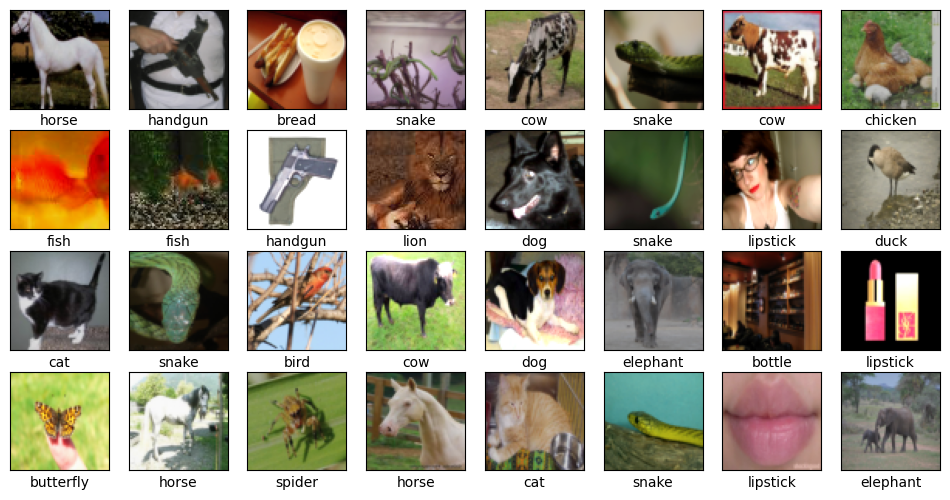

In [286]:
visualize_data(images, labels)

**For questions 3.1 to 3.7, you'll need to write your own model in a way that makes it easy for you to experiment with different architectures and parameters. The goal is to be able to pass the parameters to initialize a new instance of `YourModel` to build different network architectures with different parameters. Below are descriptions of some parameters for `YourModel`:**

1. `Block confirguration`: Our network consists of many blocks. Each block has the pattern `[conv, batch norm, activation, conv, batch norm, activation, max pool, dropout]`. All convolutional layers have filter size $(3, 3)$, strides $(1, 1)$ and padding = 1, and all max pool layers have strides $(2, 2)$, kernel size $2$, and padding = 0. The network will consists of a few blocks before applying a linear layer to output the logits for the softmax layer.

2. `list_feature_maps`: the number of feature maps in the blocks of the network. For example, if `list_feature_maps = [16, 32, 64]`, our network has three blocks with the input_channels or number of feature maps are `16, 32`, and `64` respectively.
3. `drop_rate`: the keep probability for dropout. Setting `drop_rate` to $0.0$ means not using dropout.
4. `batch_norm`: the batch normalization function is used or not. Setting `batch_norm` to `false` means not using batch normalization.
5. `use_skip`: the skip connection is used in the blocks or not. Setting this to `true` means that we use `1x1` Conv2D with `strides=2` for the skip connection.
6. At the end, you need to apply `global average pooling (GAP)` (`AdaptiveAvgPool2d((1, 1))`) to flatten the 3D output tensor before defining the output linear layer for predicting the labels.



Here is the model confirguration of `YourCNN` if the `list_feature_maps = [16, 32, 64]` and `batch_norm = true`.

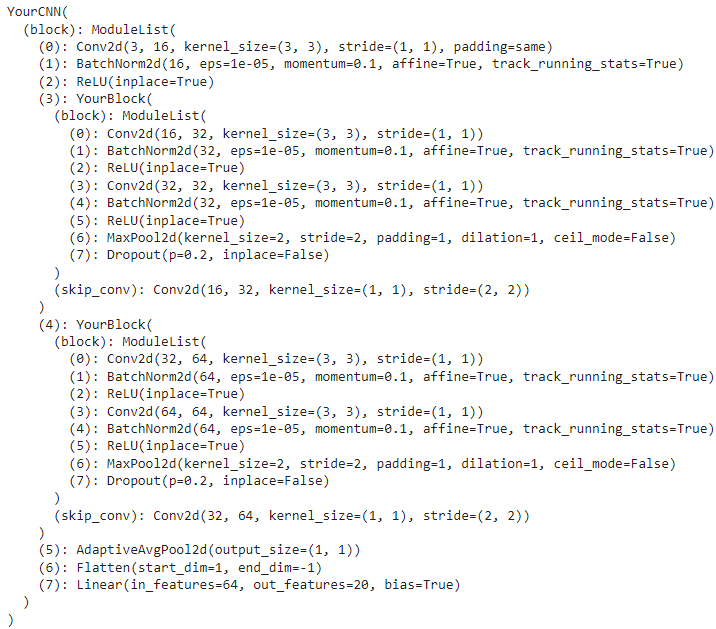

<span style="color:red">**Question 3.1:**</span> **You need to implement the aforementioned CNN**.

**First, you need to implement the block of our CNN in the class `YourBlock`. You can ignore `use_skip` and `skip connection` for simplicity. However, you cannot earn full marks for this question.**

<div style="text-align: right"> <span style="color:red">[6 points]</span> </div>

In [287]:
import torch
import torch.nn as nn

class YourBlock(nn.Module):
    def __init__(self, in_feature_maps, out_feature_maps, drop_rate=0.2, batch_norm=True, use_skip=True):
        super(YourBlock, self).__init__()
        self.use_skip = use_skip

        # Main path layers
        layers = []
        
        # First conv layer
        layers.append(nn.Conv2d(in_feature_maps, out_feature_maps, kernel_size=3, padding=1, stride=1))
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_feature_maps))
        layers.append(nn.ReLU(inplace=True))
        
        # Second conv layer
        layers.append(nn.Conv2d(out_feature_maps, out_feature_maps, kernel_size=3, padding=1, stride=1))
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_feature_maps))
        layers.append(nn.ReLU(inplace=True))

        # Max Pooling layer
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))

        # Dropout layer
        if drop_rate > 0.0:
            layers.append(nn.Dropout(p=drop_rate))

        # Store the block as a module list
        self.block = nn.ModuleList(layers)

        # Skip connection: 1x1 convolution with stride 2
        if use_skip:
            self.skip_conv = nn.Conv2d(in_feature_maps, out_feature_maps, kernel_size=1, stride=2)

    def forward(self, x):
        # Main path
        out = x
        for layer in self.block:
            out = layer(out)
        
        # Skip connection path
        if self.use_skip:
            skip_out = self.skip_conv(x)
        else:
            skip_out = x  # No downsampling if skip is not used

        # Combine skip connection with main path
        out += skip_out
        return out
    
YourBlock(16, 31, drop_rate=0.2, batch_norm=True, use_skip=True)



YourBlock(
  (block): ModuleList(
    (0): Conv2d(16, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(31, 31, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (skip_conv): Conv2d(16, 31, kernel_size=(1, 1), stride=(2, 2))
)

**Second, you need to use the above `YourBlock` to implement the class `YourCNN`**.

<div style="text-align: right"> <span style="color:red">[6 points]</span> </div>

In [288]:
class YourCNN(nn.Module):
    def __init__(self, list_feature_maps = [16, 32, 64], drop_rate = 0.2, batch_norm= True, use_skip = True):
        super(YourCNN, self).__init__()
        layers = []


        # Initial Conv layer (input block)
        layers.append(nn.Conv2d(3, list_feature_maps[0], kernel_size=3, stride=1, padding=1))
        if batch_norm:
            layers.append(nn.BatchNorm2d(list_feature_maps[0]))
        layers.append(nn.ReLU(inplace=True))

        # Add YourBlock layers
        in_feature_maps = list_feature_maps[0]
        for out_feature_maps in list_feature_maps[1:]:
            layers.append(YourBlock(in_feature_maps, out_feature_maps, drop_rate=drop_rate, batch_norm=batch_norm, use_skip=use_skip))
            in_feature_maps = out_feature_maps

        # Global Average Pooling
        layers.append(nn.AdaptiveAvgPool2d((1, 1)))

        # Flatten the output
        layers.append(nn.Flatten(start_dim=1))

        # Linear layer for classification (output 20 classes)
        layers.append(nn.Linear(list_feature_maps[-1], 20))

        # Store the entire network as a module list
        self.block = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.block:
            x = layer(x)
        return x

**We declare `my_cnn` from `YourCNN` as follows**.

In [289]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_cnn = YourCNN(list_feature_maps = [16, 32, 64], use_skip = True)
my_cnn = my_cnn.to(device)
print(my_cnn)

YourCNN(
  (block): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): YourBlock(
      (block): ModuleList(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Dropout(p=0.2, inplace=False)
      )
      (skip_conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
    )
    (4): YourBlock(
      (block): ModuleList(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)

**We declare the optimizer and the loss function.**

In [290]:
# Loss and optimizer
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_cnn.parameters(), lr=learning_rate)

**Here are the codes to compute the loss and accuracy.**

In [291]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def compute_loss(model, loss_fn, loader):
  loss = 0
  # Set model to eval mode for inference
  model.eval()
  with torch.no_grad():  # No need to track gradients for validation
    for (batchX, batchY) in loader:
      # Move data to the same device as the model
      batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device).type(torch.long)
      loss += loss_fn(model(batchX), batchY)
  # Set model back to train mode
  model.train()
  return float(loss)/len(loader)

In [292]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def compute_acc(model, loader):
    correct = 0
    totals = 0
    # Set model to eval mode for inference
    model.eval()
    for (batchX, batchY) in loader:
        # Move batchX and batchY to the same device as the model
        batchX, batchY = batchX.to(device).type(torch.float32), batchY.to(device)
        outputs = model(batchX)  # feed batch to the model
        totals += batchY.size(0)  # accumulate totals with the current batch size
        predicted = torch.argmax(outputs.data, 1)  # get the predicted class
        # Move batchY to the same device as predicted for comparison
        correct += (predicted == batchY).sum().item()
    return correct / totals

**Here is the code to train our model.**

In [293]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def fit(model= None, train_loader = None, valid_loader= None, optimizer = None,
        num_epochs = 50, verbose = True, seed= 1234):
  torch.manual_seed(seed)
  # Move the model to the device before initializing the optimizer
  model.to(device) # Move the model to the GPU

  if optimizer == None:
    optim = torch.optim.Adam(model.parameters(), lr = 0.001) # Now initialize optimizer with model on GPU
  else:
    optim = optimizer
  history = dict()
  history['val_loss'] = list()
  history['val_acc'] = list()
  history['train_loss'] = list()
  history['train_acc'] = list()

  for epoch in range(num_epochs):
    model.train()
    for (X, y) in train_loader:
      # Move input data to the same device as the model
      X,y = X.to(device), y.to(device)
      # Forward pass
      outputs = model(X.type(torch.float32)) # X is already on the correct device
      loss = loss_fn(outputs, y.type(torch.long))
      # Backward and optimize
      optim.zero_grad()
      loss.backward()
      optim.step()
    #losses and accuracies for epoch
    val_loss = compute_loss(model, loss_fn, valid_loader)
    val_acc = compute_acc(model, valid_loader)
    train_loss = compute_loss(model, loss_fn, train_loader)
    train_acc = compute_acc(model, train_loader)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    if not verbose: #verbose = True means we do show the training information during training
      print(f"Epoch {epoch+1}/{num_epochs}")
      print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%")
  return history

In [294]:
history = fit(model= my_cnn, train_loader=train_loader, valid_loader = val_loader, optimizer = optimizer, num_epochs= 10, verbose = False)

Epoch 1/10
train loss= 2.2728 - train acc= 29.89% - valid loss= 2.3110 - valid acc= 26.93%
Epoch 2/10
train loss= 2.0127 - train acc= 38.56% - valid loss= 2.0670 - valid acc= 38.33%
Epoch 3/10
train loss= 1.9044 - train acc= 40.03% - valid loss= 1.9716 - valid acc= 36.33%
Epoch 4/10
train loss= 1.8942 - train acc= 39.12% - valid loss= 1.9540 - valid acc= 37.80%
Epoch 5/10
train loss= 1.7182 - train acc= 45.55% - valid loss= 1.7607 - valid acc= 42.87%
Epoch 6/10
train loss= 1.6486 - train acc= 49.14% - valid loss= 1.6755 - valid acc= 49.42%
Epoch 7/10
train loss= 1.5228 - train acc= 50.73% - valid loss= 1.5581 - valid acc= 51.95%
Epoch 8/10
train loss= 1.4840 - train acc= 52.48% - valid loss= 1.5656 - valid acc= 48.15%
Epoch 9/10
train loss= 1.4594 - train acc= 53.26% - valid loss= 1.5390 - valid acc= 51.74%
Epoch 10/10
train loss= 1.6354 - train acc= 48.97% - valid loss= 1.7028 - valid acc= 45.62%


<span style="color:red">**Question 3.2:**</span> **Now, let us tune the number of blocks $use\_skip \in \{true,false\}$ and $learning\_rate \in \{0.001, 0.0005\}$. Write your code for this tuning and report the result of the best model on the testing set. Note that you need to show your code for tuning and evaluating on the test set to earn the full marks. During tuning, you can set the instance variable `verbose` of your model to `True` for not showing the training details of each epoch.**

Note that for this question, depending on your computational resource, you can choose `list_feature_maps= [32, 64]` or `list_feature_maps= [16, 32, 64]`.

<div style="text-align: right"> <span style="color:red">[3 points]</span> </div>

In [295]:
import itertools

# Define the hyperparameters to tune
use_skip_options = [True, False]
learning_rate_options = [0.001, 0.0005]
list_feature_maps = [16, 32, 64]  # Can also be [32, 64] for computational efficiency

# Create a grid of hyperparameter combinations
hyperparameter_combinations = list(itertools.product(use_skip_options, learning_rate_options))

# Dictionary to store results for each combination
results = {}

# Training, tuning, and testing the model
for use_skip, learning_rate in hyperparameter_combinations:
    print(f"Tuning with use_skip={use_skip}, learning_rate={learning_rate}")
    
    # Instantiate the model
    model = YourCNN(list_feature_maps=list_feature_maps, use_skip=use_skip).to(device)

    # Define optimizer with the current learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    history = fit(model=model, train_loader=train_loader, valid_loader=val_loader, 
                  optimizer=optimizer, num_epochs=10, verbose=False)

    # Get validation accuracy and loss after tuning
    val_acc = history['val_acc'][-1]
    val_loss = history['val_loss'][-1]

    # Save results for this combination
    results[(use_skip, learning_rate)] = {'val_acc': val_acc, 'val_loss': val_loss}

# Find the best combination based on validation accuracy
best_combination = max(results, key=lambda x: results[x]['val_acc'])
best_use_skip, best_learning_rate = best_combination
print(f"Best combination: use_skip={best_use_skip}, learning_rate={best_learning_rate}")

# Retrain the model on the best hyperparameters
best_model = YourCNN(list_feature_maps=list_feature_maps, use_skip=best_use_skip).to(device)
best_optimizer = torch.optim.Adam(best_model.parameters(), lr=best_learning_rate)

# Train the best model (optionally, train for more epochs)
best_history = fit(model=best_model, train_loader=train_loader, valid_loader=val_loader, 
                   optimizer=best_optimizer, num_epochs=10, verbose=False)

# Evaluate the best model on the test set
test_acc = compute_acc(best_model, val_loader)
test_loss = compute_loss(best_model, loss_fn, val_loader)

print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")



Tuning with use_skip=True, learning_rate=0.001
Epoch 1/10
train loss= 2.2389 - train acc= 31.62% - valid loss= 2.2666 - valid acc= 30.41%


In [ ]:
# from now on do all trainings with the best model
model = best_model

**Please note that you are struggling in implementing the aforementioned CNN. You can use the MiniVGG network in our labs for doing the following questions. However, you cannot earn any mark for 3.1 and 3.2.**

<span style="color:red">**Question 3.3:**</span> **Exploring Data Mixup Technique for Improving Generalization Ability.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

Data mixup is another super-simple technique used to boost the generalization ability of deep learning models. You need to incoroporate data mixup technique to the above deep learning model and experiment its performance. There are some papers and documents for data mixup as follows:
- Main paper for data mixup [link for main paper](https://openreview.net/pdf?id=r1Ddp1-Rb) and a good article [article link](https://www.inference.vc/mixup-data-dependent-data-augmentation/).

You need to extend your model developed above, train a model using data mixup, and write your observations and comments about the result.

In [ ]:
#Your code here

from torchvision.transforms import v2

NUM_CLASSES = 20  # Since your dataset has 20 animal classes

# Initialize MixUp
mixup = v2.MixUp(num_classes=NUM_CLASSES)

criterion = nn.CrossEntropyLoss()

# Modify your training loop to include MixUp
for images, labels in train_loader:
    # Apply MixUp on the batch
    images, labels = mixup(images, labels)
    
    # Continue with the rest of the training loop (forward pass, loss computation, etc.)
    # Example:
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()


<span style="color:red">**Question 3.4:**</span> **Exploring CutMix Technique for Improving Generalization Ability.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

Cut mix is another super-simple technique used to boost the generalization ability of deep learning models. You need to incoroporate data mix technique to the above deep learning model and experiment its performance. There are some papers and documents for data mix as follows:
- Main paper for Cutmix [link for main paper](https://arxiv.org/pdf/1905.04899v2) and a good article [article link](https://shorturl.at/TNwjv).

You need to extend your model developed above, train a model using cut mix, and write your observations and comments about the result.

In [ ]:
import torch
import numpy as np

def rand_bbox(size, lam):
    """
    Generate a random bounding box with respect to the given lambda (lam).
    """
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Center of the bounding box
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    # Bounding box coordinates
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix_data(x, y, alpha=1.0):
    """
    Apply CutMix augmentation to the input images and adjust labels.
    """
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0]).to(x.device)
    y_a = y
    y_b = y[rand_index]

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2]

    # Adjust lambda based on the area of the cut
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return x, y_a, y_b, lam

def cutmix_criterion(criterion, pred, y_a, y_b, lam):
    """
    Compute the criterion using CutMix-adjusted targets.
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


epochs = 10 

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Apply CutMix
        inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets, alpha=1.0)
        outputs = model(inputs)
        loss = cutmix_criterion(criterion, outputs, targets_a, targets_b, lam)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}')


Epoch [1/10], Loss: 6.047107685817761
Epoch [2/10], Loss: 4.281122091557649


KeyboardInterrupt: 

<span style="color:red">**Question 3.5:**</span> Implement the **one-versus-all (OVA)** loss. The details are as follows:
- You need to apply `the sigmoid activation function` to logits $h = [h_1, h_2,...,h_M]$ instead of `the softmax activation` function as usual to obtain $p = [p_1, p_2,...,p_M]$, meaning that $p_i = sigmoid(h_i), i=1,...,M$. Note that $M$ is the number of classes.
- Given a data example $x$ with the ground-truth label $y$, the idea is to maximize the likelihood $p_y$ and to minimize the likelihoods $p_i, i \neq y$. Therefore, the objective function is to find the model parameters to
  - $\max\left\{ \log p_{y}+\sum_{i\neq y}\log(1-p_{i})\right\}$ or equivalently $\min\left\{ -\log p_{y}-\sum_{i\neq y}\log(1-p_{i})\right\}$.
  - For example, if $M=3$ and $y=2$, you need to minimize $\min\left\{ -\log(1-p_{1})-\log p_{2}-\log(1-p_{3})\right\}$.

Compare the model trained with the OVA loss and the same model trained with the standard cross-entropy loss.

<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>



In [ ]:
import torch
import torch.nn as nn

# Define the OVA loss function
def ova_loss(logits, targets):
    """
    One-Versus-All (OVA) loss function.

    Args:
        logits: Output logits from the model (before activation), shape (batch_size, num_classes).
        targets: Ground truth labels, shape (batch_size,).
    
    Returns:
        Loss value as a scalar.
    """
    # Apply sigmoid to each logit
    probabilities = torch.sigmoid(logits)  # shape: (batch_size, num_classes)
    
    # Create a tensor for ground truth labels in one-hot encoded format
    num_classes = logits.size(1)  # M classes
    one_hot_targets = torch.eye(num_classes)[targets].to(logits.device)  # One-hot encoding, shape: (batch_size, num_classes)
    
    # For the correct class (targets), maximize log(p_y), for others, minimize log(1 - p_i)
    pos_class_term = one_hot_targets * torch.log(probabilities)  # Log-likelihood of the correct class, shape: (batch_size, num_classes)
    neg_class_term = (1 - one_hot_targets) * torch.log(1 - probabilities)  # Log-likelihood of incorrect classes
    
    # Total OVA loss
    loss = -torch.sum(pos_class_term + neg_class_term, dim=1)  # Sum over all classes, then take the mean
    return torch.mean(loss)  # Return mean OVA loss

# Model training using OVA loss
def train_model_ova(model, train_loader, optimizer, epochs):
    model.train()
    criterion = ova_loss  # Use the OVA loss
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            logits = model(inputs)  # Raw logits (before softmax or sigmoid)
            
            # Compute OVA loss
            loss = criterion(logits, targets)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{epochs}], OVA Loss: {running_loss/len(train_loader)}')

# Define cross-entropy training for comparison
def train_model_cross_entropy(model, train_loader, optimizer, epochs):
    model.train()
    criterion = nn.CrossEntropyLoss()  # Standard Cross-Entropy Loss
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            logits = model(inputs)  # Raw logits (before softmax)
            
            # Compute cross-entropy loss
            loss = criterion(logits, targets)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{epochs}], Cross-Entropy Loss: {running_loss/len(train_loader)}')

# Usage Example
epochs = 10  # Number of training epochs

# Train the model using OVA loss
train_model_ova(model, train_loader, optimizer, epochs)

# Train the model using Cross-Entropy loss for comparison
train_model_cross_entropy(model, train_loader, optimizer, epochs)


In [ ]:
#Your explanation here



<span style="color:red">**Question 3.6:**</span> **Attack your best obtained model with PGD attacks with $\epsilon= 0.0313, k=20, \eta= 0.002$ on the valid set. Write the code for the attacks and report the robust accuracies. Also choose a random set of 20 clean images in the testing set and visualize the original and attacked images.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# PGD attack function
def pgd_attack(model, input_image, input_label=None,
               epsilon=0.0313,
               num_steps=20,
               step_size=0.002,
               clip_value_min=0.,
               clip_value_max=1.0):

    if isinstance(input_image, np.ndarray):
        input_image = torch.tensor(input_image, dtype=torch.float32)

    if isinstance(input_label, np.ndarray):
        input_label = torch.tensor(input_label)

    # Ensure the model is in evaluation mode
    model.eval()

    # Ensure input image requires gradients
    input_image = input_image.clone().detach().to(device)
    input_image.requires_grad = True

    # Create a copy of the input image and set it to require gradients
    adv_image = input_image.clone().detach().requires_grad_(True)

    # Random initialization around input_image (this will be the noise)
    random_noise = torch.FloatTensor(input_image.shape).uniform_(-epsilon, epsilon).to(device)
    noise_image = random_noise + input_image
    noise_image = torch.clamp(noise_image, clip_value_min, clip_value_max).detach()

    # If no input label is provided, use the model's prediction
    if input_label is None:
        output = model(adv_image)
        input_label = torch.argmax(output, dim=1)

    # Perform PGD attack
    for _ in range(num_steps):
        adv_image.requires_grad_(True)  # Ensure requires_grad is True in each iteration
        output = model(adv_image)
        loss = nn.CrossEntropyLoss()(output, input_label)
        model.zero_grad()
        loss.backward()

        # Perform the PGD step
        with torch.no_grad():
            gradient = adv_image.grad.sign()
            adv_image = adv_image + step_size * gradient
            adv_image = torch.clamp(adv_image, input_image - epsilon, input_image + epsilon)
            adv_image = torch.clamp(adv_image, clip_value_min, clip_value_max)

    return input_image.detach(), noise_image.detach(), adv_image.detach()

In [ ]:
from sklearn.metrics import accuracy_score

from sklearn.metrics import accuracy_score

# Evaluate model under PGD attack
def evaluate_pgd_attack(model, val_loader, epsilon=0.0313, num_steps=20, step_size=0.002):
    correct = 0
    total = 0

    # Set model to evaluation mode
    model.eval()

    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Perform PGD attack on the batch of validation images
        _, _, adv_images = pgd_attack(model, images, labels, epsilon=epsilon, num_steps=num_steps, step_size=step_size)

        # Get model predictions on the adversarial images (with torch.no_grad)
        with torch.no_grad():
            outputs = model(adv_images)
            _, predicted = torch.max(outputs.data, 1)

            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate robust accuracy
    robust_accuracy = correct / total * 100
    print(f'Robust Accuracy after PGD attack: {robust_accuracy:.2f}%')

    return robust_accuracy


# Assuming you have a DataLoader 'val_loader' and 'test_loader'

evaluate_pgd_attack(model, val_loader, epsilon=0.0313, num_steps=20, step_size=0.002)

# Evaluate adversarial accuracy on the test set

# y_adv = []
# y_true = []

# model.eval()
# for data, target in val_loader:
#     data, target = data.to(device), target.to(device)
#     data_adv = pgd_attack(model, data, target, epsilon=0.3, num_steps=20, step_size=0.01,
#                           clip_value_min=0.0, clip_value_max=1.0)
#     output_adv = model(data_adv)
#     pred_adv = output_adv.argmax(dim=1, keepdim=True)
#     y_adv.extend(pred_adv.squeeze().cpu().numpy())
#     y_true.extend(target.numpy())

# test_adv_acc = accuracy_score(y_true, y_adv)
# print("Test adversarial accuracy: {}%".format(test_adv_acc*100))


Robust Accuracy after PGD attack: 3.27%


3.2734952481520594

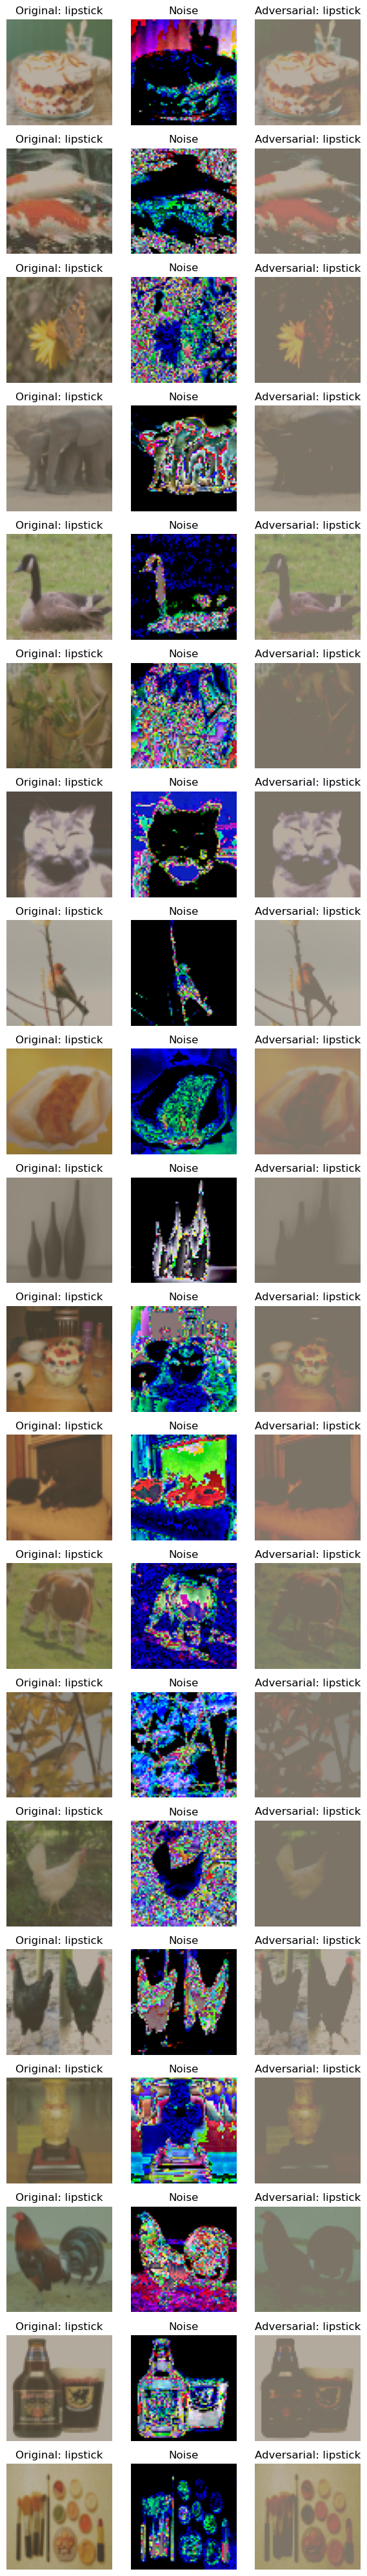

In [ ]:
def revert_preprocess(tensor):
    # Define the inverse normalization
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    inv_normalize = transforms.Normalize(
        mean=-mean / std,
        std=1.0 / std
    )

    # Apply inverse normalization
    tensor = inv_normalize(tensor)

    # Convert tensor to PIL image
    to_pil = transforms.ToPILImage()
    img = to_pil(tensor)

    return img

def visualize_attack(model, test_loader, num_images=20, epsilon=0.0313, num_steps=20, step_size=0.002):
    model.eval()

    images_shown = 0
    plt.figure(figsize=(6, 2 * num_images))

    for images, labels in test_loader:
        if images_shown >= num_images:
            break
        images, labels = images.to(device), labels.to(device)

        for i in range(len(images)):
            if images_shown >= num_images:
                break

            input_image, noise_image, adv_image = pgd_attack(model, images[i:i+1], labels[i:i+1],
                                                             epsilon=epsilon, num_steps=num_steps, step_size=step_size)

            # Get original and adversarial predictions
            with torch.no_grad():
                orig_pred = torch.argmax(model(input_image), dim=1).item()
                orig_pred = class_names[orig_pred]
                # adv_pred = torch.argmax(model(adv_image), dim=1).item()
                adv_pred = class_names[torch.argmax(model(adv_image), dim=1).item()]                
            

            # Convert tensors back to images for visualization
            img_pil = revert_preprocess(input_image.squeeze(0))
            img_pgd_pil = revert_preprocess(adv_image.squeeze(0))
            img_noise_pil = np.clip(np.abs(np.array(img_pgd_pil) - np.array(img_pil)) * 20, 0, 255).astype(np.uint8)

            # Plot original image, noise, and adversarial image
            plt.subplot(num_images, 3, 3 * images_shown + 1)
            plt.imshow(img_pil)
            plt.title(f'Original: {orig_pred}')
            plt.axis('off')

            plt.subplot(num_images, 3, 3 * images_shown + 2)
            plt.imshow(img_noise_pil)
            plt.title(f'Noise')
            plt.axis('off')

            plt.subplot(num_images, 3, 3 * images_shown + 3)
            plt.imshow(img_pgd_pil)
            plt.title(f'Adversarial: {adv_pred}')
            plt.axis('off')

            images_shown += 1

    plt.tight_layout()
    plt.show()

# Assuming you have a DataLoader 'test_loader'
# This visualizes 20 random clean and adversarial images
visualize_attack(model, val_loader, num_images=20, epsilon=0.0313, num_steps=20, step_size=0.002)


<span style="color:red">**Question 3.7:**</span> **Train a robust model using adversarial training with PGD ${\epsilon= 0.0313, k=10, \eta= 0.002}$. Write the code for the adversarial training and report the robust accuracies. After finishing the training, you need to store your best robust model in the folder `./models` and load the model to evaluate the robust accuracies for PGD and FGSM attacks with $\epsilon= 0.0313, k=20, \eta= 0.002$ on the valid set.**
   
<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

In [ ]:
#Your code here

# 1. train the model with PGD
# 2. store the best model in the folder
# 3. load the best model and evaluate the model with PGD attack
# 4. visualize the adversarial images label and the original label
# 5. attack the model with FGSM and evaluate the model with FGSM attack
# 6. visualize the adversarial images label and the original label

# Define FGSM attack function
from torch.nn.modules.activation import F


def fgsm_attack(model, input_image, input_label=None,
                epsilon=0.3,
                clip_value_min=0.,
                clip_value_max=1.0):
    """
    Args:
        model: pretrained model
        input_image: original (clean) input image (tensor)
        input_label: original label (tensor, categorical representation)
        epsilon: perturbation boundary
        clip_value_min, clip_value_max: range of valid input
        from_logits = True: attack from logits otherwise attack from prediction probabilities
    Note:
        we expect the output of model should be logits vector
    """

    if type(input_image) is np.ndarray:
        input_image = torch.tensor(input_image, requires_grad=True)

    if type(input_label) is np.ndarray:
        input_label = torch.tensor(input_label)

    # Ensure the model is in evaluation mode
    model.eval()

    # Create a copy of the input image and set it to require gradients
    adv_image = input_image.clone().detach().requires_grad_(True)  # Ensure requires_grad is True

    # Random initialization around input_image
    random_noise = torch.FloatTensor(input_image.shape).uniform_(-epsilon, epsilon)
    adv_image = adv_image + random_noise
    adv_image = torch.clamp(adv_image, clip_value_min, clip_value_max).detach().requires_grad_(True)

    output = model(adv_image)

    if input_label is not None:
        loss = F.cross_entropy(output, input_label)  # use ground-truth label to attack
    else:
        pred_label = output.argmax(dim=1)  # use predicted label to attack
        loss = F.cross_entropy(output, pred_label)

    model.zero_grad()
    loss.backward()
    gradient = input_image.grad.data
    adv_image = input_image + epsilon * gradient.sign()
    adv_image = torch.clamp(adv_image, clip_value_min, clip_value_max)

    return adv_image.detach()


In [ ]:
from sklearn.metrics import accuracy_score

from sklearn.metrics import accuracy_score

# Evaluate model under PGD attack
def evaluate_attack(attack, model, val_loader, epsilon=0.0313, num_steps=20, step_size=0.002):
    correct = 0
    total = 0

    # Set model to evaluation mode
    model.eval()

    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        if attack == 'pgd':
            # Perform PGD attack on the batch of validation images
            _, _, adv_images = pgd_attack(model, images, labels, epsilon=epsilon, num_steps=num_steps, step_size=step_size)
        elif attack == 'fgsm':
            # Perform FGSM attack on the batch of validation images
            adv_images = fgsm_attack(model, images, labels, epsilon=epsilon)

        # Get model predictions on the adversarial images (with torch.no_grad)
        with torch.no_grad():
            outputs = model(adv_images)
            _, predicted = torch.max(outputs.data, 1)

            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate robust accuracy
    robust_accuracy = correct / total * 100
    print(f'Robust Accuracy after PGD attack: {robust_accuracy:.2f}%')

    return robust_accuracy


# Assuming you have a DataLoader 'val_loader' and 'test_loader'

# evaluate_pgd_attack(model, val_loader, epsilon=0.0313, num_steps=20, step_size=0.002)

# Evaluate adversarial accuracy on the test set

# y_adv = []
# y_true = []

# model.eval()
# for data, target in val_loader:
#     data, target = data.to(device), target.to(device)
#     data_adv = pgd_attack(model, data, target, epsilon=0.3, num_steps=20, step_size=0.01,
#                           clip_value_min=0.0, clip_value_max=1.0)
#     output_adv = model(data_adv)
#     pred_adv = output_adv.argmax(dim=1, keepdim=True)
#     y_adv.extend(pred_adv.squeeze().cpu().numpy())
#     y_true.extend(target.numpy())

# test_adv_acc = accuracy_score(y_true, y_adv)
# print("Test adversarial accuracy: {}%".format(test_adv_acc*100))


In [ ]:
# # import optimizer
# import torch.optim as optim

# # Training function with adversarial examples
# def adversarial_train(model, train_loader, val_loader, num_epochs, epsilon=0.0313, num_steps=10, step_size=0.002, save_path='./models/best_robust_model.pth'):
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
#     criterion = nn.CrossEntropyLoss()
#     best_acc = 0

#     for epoch in range(num_epochs):
#         model.train()
#         for data, target in train_loader:
#             data, target = data.to(device), target.to(device)

#             # Generate adversarial examples using PGD
#             input_img, noise_img, adv_img = pgd_attack(model, data, target, epsilon=epsilon, num_steps=num_steps, step_size=step_size)

#             # Compute the loss on adversarial examples
#             optimizer.zero_grad()
#             output = model(adv_img)
#             loss = criterion(output, target)
#             loss.backward()
#             optimizer.step()
            
#             # Evaluate on validation set and save best model
#             val_acc = evaluate_attack("pgd", model, val_loader, epsilon=0.0313, num_steps=20, step_size=0.002)
#             if val_acc > best_acc:
#                 best_acc = val_acc
#                 if not os.path.exists('./models'):
#                     os.makedirs('./models')
#                 torch.save(model.state_dict(), save_path)
#             print(f'Epoch {epoch+1}, Validation Robust Accuracy: {val_acc:.2f}%')
            
# adversarial_train(model, train_loader, val_loader, num_epochs=5)



Robust Accuracy after PGD attack: 5.17%
Epoch 1, Validation Robust Accuracy: 5.17%
Robust Accuracy after PGD attack: 5.07%
Epoch 1, Validation Robust Accuracy: 5.07%
Robust Accuracy after PGD attack: 5.49%
Epoch 1, Validation Robust Accuracy: 5.49%


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score
import torch.optim as optim

# Initialize model, optimizer, and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training function with adversarial examples
def train_step_adv(model, x, x_adv, y, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    logits = model(x)
    logits_adv = model(x_adv)
    loss = (criterion(logits, y) + criterion(logits_adv, y)) / 2
    loss.backward()
    optimizer.step()

    pred_adv = logits_adv.argmax(dim=1, keepdim=True)
    return loss.item(), pred_adv

# Metrics
train_loss = []
test_acc_clean = []
test_acc_pgd = []


# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    y_pred = []
    y_true = []
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        _, _, x_adv = pgd_attack(model, x, y, epsilon=0.3, num_steps=10, step_size=0.01, clip_value_min=0.0, clip_value_max=1.0)
        loss, pred_adv= train_step_adv(model, x, x_adv, y, optimizer, criterion)

        # Log
        total_loss += loss
        y_pred.extend(pred_adv.squeeze().cpu().numpy())
        y_true.extend(y.cpu().numpy())
    train_loss = total_loss / len(train_loader)
    train_acc = accuracy_score(y_true, y_pred)

    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Training Acc: {train_acc*100:.2f}%, ")

Epoch 1, Training Loss: 3.1397, Training Acc: 4.87%, 
Epoch 2, Training Loss: 3.0679, Training Acc: 4.84%, 


KeyboardInterrupt: 

In [ ]:
# Load the model and evaluate it
def evaluate_model(model, val_loader):
    model.load_state_dict(torch.load('./models/best_robust_model.pth'))
    model = model.to(device)

    # Evaluate with PGD attack
    print("Evaluating PGD attack...")
    pgd_robust_acc = evaluate_attack("pgd", model, val_loader, epsilon=0.0313, num_steps=20, step_size=0.002)
    print(f"PGD Robust Accuracy: {pgd_robust_acc:.2f}%")

    # Evaluate with FGSM attack
    print("Evaluating FGSM attack...")
    fgsm_robust_acc = evaluate_attack("fgsm", model, val_loader, epsilon=0.0313)
    print(f"FGSM Robust Accuracy: {fgsm_robust_acc:.2f}%")
    
evaluate_model(model, val_loader)

<span style="color:red">**Question 3.8 (Kaggle competition)**</span>
<div style="text-align: right"> <span style="color:red">[10 points]</span> </div10

You can reuse the best model obtained in this assignment or develop new models to evaluate on the **testing set of the FIT3181/5215 Kaggle competion**. However, to gain any points for this question, your testing accuracy must **exceed** the accuracy threshold from a base model developed by us as shown in the leader board of the competition.

The marks for this question are as follows:
- If you are in *top 10%* of your cohort, you gain *10 points*.
- If you are in *top 20%* of your cohort, you gain *8 points*.
- If you are in *top 30%* of your cohort, you gain *6 points*.
- If you *beat* our base model, you gain *4 points*.

---
**<div style="text-align: center"> <span style="color:black">END OF ASSIGNMENT</span> </div>**
**<div style="text-align: center"> <span style="color:black">GOOD LUCK WITH YOUR ASSIGNMENT 1!</span> </div>**